In [9]:
# Import necessary libraries

import os
import sys
import copy
import pickle
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras.api._v2.keras as keras
import keras.backend as K
from keras.optimizers.legacy import Adam
from keras.optimizers import SGD
from keras import callbacks
from keras.models import Model
from keras.layers import Masking, Layer, Dense, Input, Activation, Lambda, BatchNormalization, Conv1D, SpatialDropout1D, Add, GlobalAveragePooling1D, LSTM, Dense, concatenate, TimeDistributed, Bidirectional, Dropout, Embedding, Attention, MultiHeadAttention, LayerNormalization, Flatten, Concatenate
from tensorflow.keras.backend import sigmoid
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import tensorflow as tf
from data_utils import *
from model_utils import *
import tensorflow as tf
from collections import Counter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Load data
train_data, train_label, train_mask, test_data, test_label, test_mask, train_text, train_audio, train_visual, test_text, test_audio, test_visual = load_data()

Max length of sequences:  110

Number of training samples: 120
Number of testing samples: 31

Train text shape: 120 samples, 110 timesteps, 100 features
Train audio shape: 120 samples, 110 timesteps, 100 features
Train visual shape: 120 samples, 110 timesteps, 512 features

Test text shape: 31 samples, 110 timesteps, 100 features
Test audio shape: 31 samples, 110 timesteps, 100 features
Test visual shape: 31 samples, 110 timesteps, 512 features



In [11]:
train_dataset, validation_dataset = create_and_split_multimodal_dataset(audio=train_audio, visual=train_visual, text=train_text, data=train_data, labels=train_label, mask=train_mask, batch_size=32, train_size=0.8, shuffle=True)
test_dataset = tf.data.Dataset.from_tensor_slices(((test_audio, test_visual, test_text, test_data), test_label, test_mask)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
class MultimodalModel(Model):
    def __init__(self, num_classes, d_model, num_heads):
        super(MultimodalModel, self).__init__()

        # Text feature processing using bi-LSTM
        self.text_mask = Masking(mask_value=0.0, input_shape=(None, 110))
        self.text_bilstm_1 = Bidirectional(LSTM(64, return_sequences=True))
        self.text_bilstm_2 = Bidirectional(LSTM(64, return_sequences=True))
        self.text_dense = Dense(d_model, activation='relu')

        # Audio feature processing using 1D CNN with padding
        self.audio_mask = Masking(mask_value=0.0, input_shape=(None, 110))
        self.audio_cnn_1 = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')
        self.audio_cnn_2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')
        self.audio_dense = Dense(d_model, activation='relu')

        # Video feature processing using CNN and Multi-Head Attention
        self.video_mask = Masking(mask_value=0.0, input_shape=(None, 110))
        self.video_attn = MultiHeadAttention(num_heads=8, key_dim=64)
        self.video_cnn_1 = Conv1D(128, kernel_size=8, activation='relu', padding='same')
        self.video_cnn_2 = Conv1D(128, kernel_size=3, activation='relu', padding='same')
        self.video_dense = Dense(d_model, activation='relu')

        # Cross-modal attention layers
        self.text_audio_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)
        self.text_video_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)

        # Final processing and classification layers
        self.concat = Concatenate()
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs, training):
        audio_features, video_features, text_features, all_features = inputs

        # Process text features
        text_features = self.text_mask(text_features)
        text_features = self.text_bilstm_1(text_features)
        text_features = self.text_bilstm_2(text_features)
        text_features = self.text_dense(text_features)

        # Process audio features
        audio_features = self.audio_mask(audio_features)
        audio_features = self.audio_cnn_1(audio_features)
        audio_features = self.audio_cnn_2(audio_features)
        audio_features = self.audio_dense(audio_features)

        # Process video features and reduce dimensionality
        video_features = self.video_mask(video_features)
        video_features = self.video_attn(video_features, video_features)
        video_features = self.video_cnn_1(video_features)
        video_features = self.video_cnn_2(video_features)
        video_features = self.video_dense(video_features)
        
        # Apply cross-modal attention between audio-video and text-video
        text_audio_attn = self.text_audio_attention(text_features, audio_features)
        text_video_attn = self.text_video_attention(text_features, video_features)
        
        # Combine features from both attention mechanisms
        combined_features = self.concat([text_features, text_audio_attn, text_video_attn])
        outputs = self.classifier(combined_features)

        # Return the final prediction
        return outputs

    def evaluate_model(self, dataset):
        
        for batch in dataset:
            (inputs, labels, mask) = batch
            predictions = self.predict(inputs)
            y_pred = np.argmax(predictions, axis=-1).flatten()
            y_true = np.argmax(labels, axis=-1).flatten()

            # Apply mask to predictions and true values
            valid_indices = np.where(mask.numpy().flatten() == 1)
            y_pred = y_pred[valid_indices]
            y_true = y_true[valid_indices]

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

            self.test_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cm': confusion_matrix(y_true, y_pred)
            }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        print(f"Precision: {self.test_metrics['precision']:.4f}")
        print(f"Recall: {self.test_metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'ang', 'sad', 'neu']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Epoch 1/10


2024-04-15 22:30:14.286290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:15.322998: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_42/output/_24'
2024-04-15 22:30:15.329877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:3

3/3 [==============================] - ETA: 0s - loss: 1.4597 - accuracy: 0.5335WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 22:30:19.055377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:19.572244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:19.649031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:19.805102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:19.863271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 10s 1s/step - loss: 1.4597 - accuracy: 0.5335 - val_loss: 1.2024 - val_accuracy: 0.6992
Epoch 2/10
3/3 [==============================] - 1s 363ms/step - loss: 1.1078 - accuracy: 0.6612 - val_loss: 1.0063 - val_accuracy: 0.6178
Epoch 3/10
3/3 [==============================] - 1s 394ms/step - loss: 0.8532 - accuracy: 0.6895 - val_loss: 0.6911 - val_accuracy: 0.7874
Epoch 4/10
3/3 [==============================] - 1s 369ms/step - loss: 0.6524 - accuracy: 0.7684 - val_loss: 0.5766 - val_accuracy: 0.8129
Epoch 5/10
3/3 [==============================] - 1s 369ms/step - loss: 0.5702 - accuracy: 0.7905 - val_loss: 0.5514 - val_accuracy: 0.7864
Epoch 6/10
3/3 [==============================] - 1s 359ms/step - loss: 0.4886 - accuracy: 0.8074 - val_loss: 0.4807 - val_accuracy: 0.8089
Epoch 7/10
3/3 [==============================] - 1s 359ms/step - loss: 0.4382 - accuracy: 0.8340 - val_loss: 0.3324 - val_accuracy: 0.8927
Epoch 8/10
3/3 [=================

2024-04-15 22:30:30.590939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:31.074446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:31.156058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:31.314895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:30:31.375247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
Test Metrics:
Accuracy: 0.7369
Precision: 0.7611
Recall: 0.7168
F1 Score: 0.7323
Confusion Matrix:


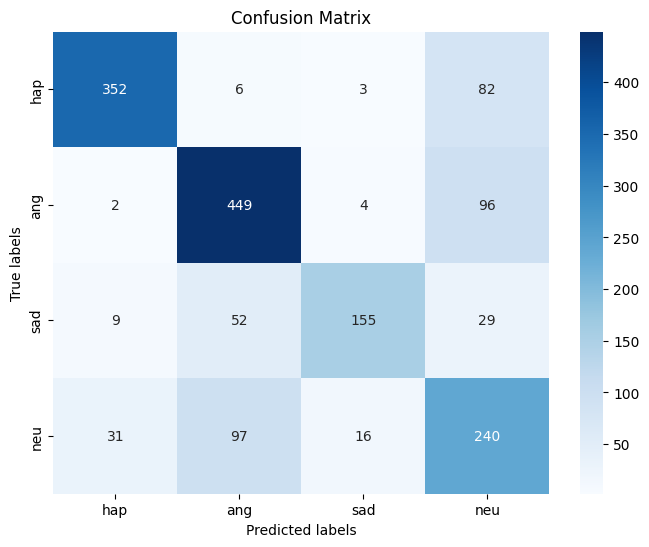

In [13]:
# Instantiate the model
multimodal_model = MultimodalModel(num_classes=5, d_model=128, num_heads=8)

# Compile the model
multimodal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
multimodal_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Evaluate the model on test dataset
multimodal_model.evaluate_model(test_dataset)

# Print test metrics
multimodal_model.print_metrics()

In [17]:
class RNNModel(Model):
    def __init__(self, num_classes, modality):
        super(RNNModel, self).__init__()
        self.num_classes = num_classes
        self.modality = modality
        
        self.mask = Masking(mask_value=0.0)
        self.bilstm1 = Bidirectional(LSTM(64, return_sequences=True))
        self.bilstm2 = Bidirectional(LSTM(64, return_sequences=True))
        self.dropout = Dropout(0.5)
        self.dense = Dense(64, activation='relu')
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        audio_features, video_features, text_features, all_features = inputs
        if self.modality == 'audio':
            inputs = audio_features
        elif self.modality == 'video':
            inputs = video_features
        elif self.modality == 'text':
            inputs = text_features
        elif self.modality == 'multimodal':
            inputs = all_features
        x = self.mask(inputs)
        x = self.bilstm1(x)
        x = self.bilstm2(x)
        x = self.dropout(x)
        x = self.dense(x)
        return self.classifier(x)

    def evaluate_model(self, dataset):
        
        for batch in dataset:
            (inputs, labels, mask) = batch
            predictions = self.predict(inputs)
            y_pred = np.argmax(predictions, axis=-1).flatten()
            y_true = np.argmax(labels, axis=-1).flatten()

            # Apply mask to predictions and true values
            valid_indices = np.where(mask.numpy().flatten() == 1)
            y_pred = y_pred[valid_indices]
            y_true = y_true[valid_indices]

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

            self.test_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cm': confusion_matrix(y_true, y_pred)
            }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        print(f"Precision: {self.test_metrics['precision']:.4f}")
        print(f"Recall: {self.test_metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'ang', 'sad', 'neu']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Epoch 1/10


2024-04-15 22:33:45.958359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:46.830998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:46.976266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:47.176877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:47.324780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:47.755765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:47.906618: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - ETA: 0s - loss: 1.4272 - accuracy: 0.4069WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 22:33:50.003260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:50.454911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:50.514284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:50.641290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 8s 1s/step - loss: 1.4272 - accuracy: 0.4069 - val_loss: 1.1193 - val_accuracy: 0.7635
Epoch 2/10


2024-04-15 22:33:50.701692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 246ms/step - loss: 1.0314 - accuracy: 0.7193 - val_loss: 0.8123 - val_accuracy: 0.7355
Epoch 3/10
3/3 [==============================] - 1s 254ms/step - loss: 0.7947 - accuracy: 0.7457 - val_loss: 0.6023 - val_accuracy: 0.7809
Epoch 4/10
3/3 [==============================] - 1s 259ms/step - loss: 0.6207 - accuracy: 0.7886 - val_loss: 0.5030 - val_accuracy: 0.8288
Epoch 5/10
3/3 [==============================] - 1s 246ms/step - loss: 0.5282 - accuracy: 0.8188 - val_loss: 0.4294 - val_accuracy: 0.8387
Epoch 6/10
3/3 [==============================] - 1s 258ms/step - loss: 0.4719 - accuracy: 0.8239 - val_loss: 0.4357 - val_accuracy: 0.8316
Epoch 7/10
3/3 [==============================] - 1s 248ms/step - loss: 0.4342 - accuracy: 0.8393 - val_loss: 0.4398 - val_accuracy: 0.8333
Epoch 8/10
3/3 [==============================] - 1s 257ms/step - loss: 0.4024 - accuracy: 0.8519 - val_loss: 0.2991 - val_accuracy: 0.8906
Epoch 9/10
3/3 [===============

2024-04-15 22:33:58.525485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:58.969870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:59.034696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:59.181533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:33:59.242531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
Test Metrics:
Accuracy: 0.7270
Precision: 0.7526
Recall: 0.7183
F1 Score: 0.7305
Confusion Matrix:


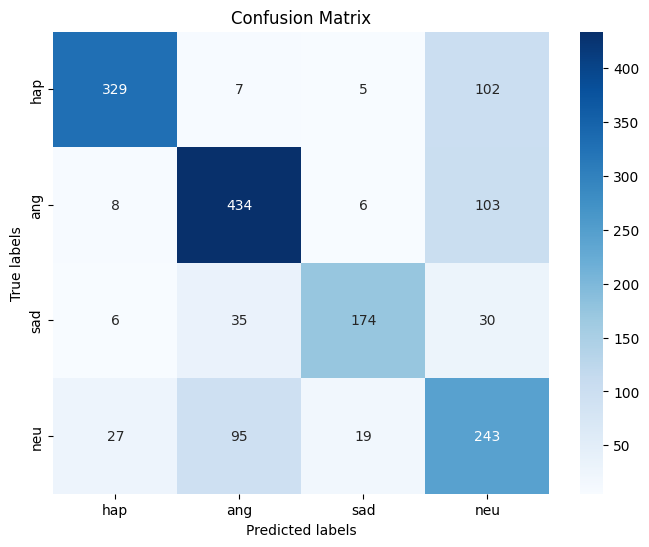

In [19]:
#RNN model for text
rnn_model = RNNModel(num_classes=5, modality='text')
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)
rnn_model.evaluate_model(test_dataset)
rnn_model.print_metrics()